In [1]:
import numpy as np
import tensorflow as tf
import PIL.Image as Image
import tensorflow_hub as hub
import matplotlib.pylab as plt

from tensorflow.keras import layers

In [2]:
from tensorflow.keras.models import load_model 
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [3]:
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape = IMAGE_SHAPE + (3,))
])

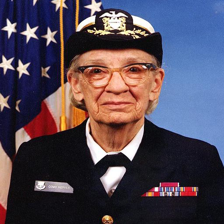

In [5]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
# Predict

predicted_class = np.argmax(result[0], axis = -1)
predicted_class

653

In [9]:
# Decode

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


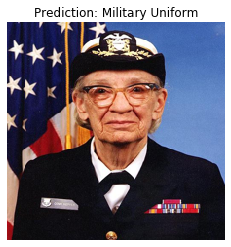

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [11]:
# Reclassify flowers using tf_hub

data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar = True)

In [12]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size = IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [13]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [14]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [15]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis = -1)]
predicted_class_names

array(['umbrella', 'daisy', "jack-o'-lantern", 'Persian cat', 'daisy',
       'mushroom', 'daisy', 'comic book', 'picket fence', 'bee', 'daisy',
       'flamingo', 'picket fence', 'daisy', 'ant', 'picket fence', 'pot',
       'vase', 'sulphur-crested cockatoo', 'tarantula', 'daisy', 'daisy',
       'cardoon', 'daisy', 'bell pepper', 'daisy', 'bee', 'daisy',
       'barn spider', "jack-o'-lantern", 'rapeseed', 'daisy'],
      dtype='<U30')

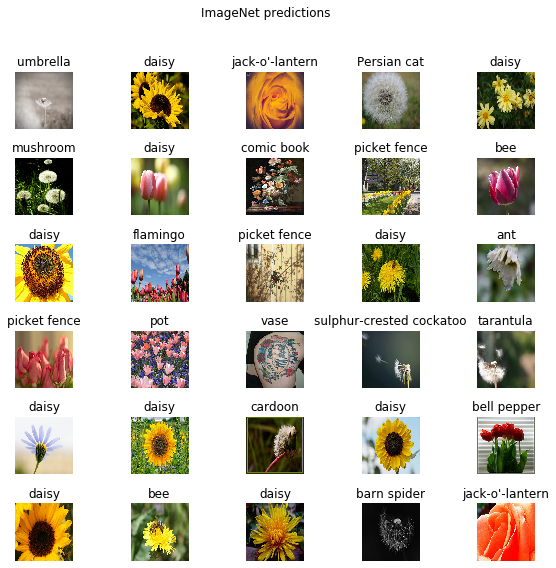

In [16]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace = 0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [17]:
# Get the Headless model

feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [18]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape = (224,224,3))

In [19]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [20]:
feature_extractor_layer.trainable = False

In [21]:
# Attach head

model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
predictions = model(image_batch)

In [23]:
predictions.shape

TensorShape([32, 5])

In [24]:
# Train

model.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
  metrics = ['acc'])

In [25]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs = None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [26]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs = 2,
                              steps_per_epoch = steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 115.0 steps
Epoch 1/2
115/115 [==============================] - 62s 542ms/step - loss: 0.6628 - acc: 0.6875
Epoch 2/2
115/115 [==============================] - 10s 89ms/step - loss: 0.3342 - acc: 0.8125


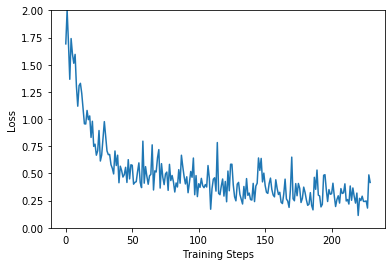

In [27]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

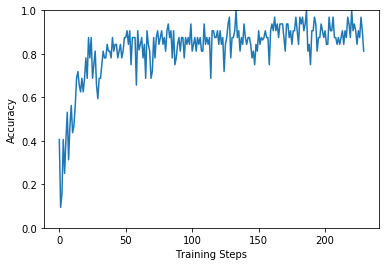

In [28]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [29]:
class_names = sorted(image_data.class_indices.items(), key = lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [30]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis = -1)
predicted_label_batch = class_names[predicted_id]

In [31]:
label_id = np.argmax(label_batch, axis = -1)

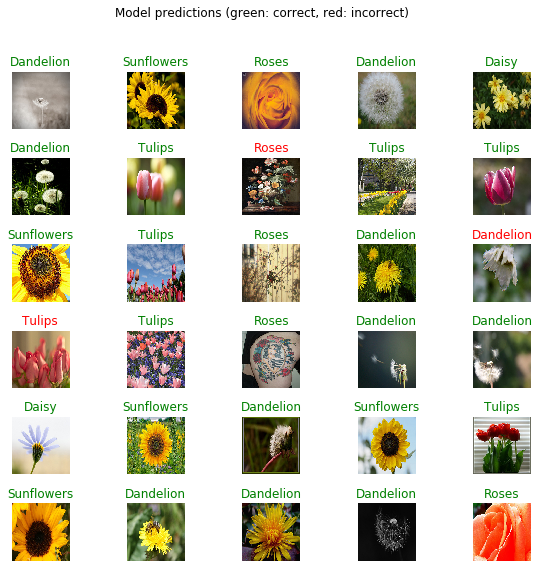

In [32]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace = 0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")